In [1]:
!pip install underthesea

In [2]:
!pip install gensim
import pandas as pd
import numpy as np
import re
import string
import torch
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
from underthesea import word_tokenize

In [3]:
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm

In [4]:
!pip install transformers torch pandas numpy

In [ ]:
import numpy as np
import pandas as pd

# Danh sách môn thể thao
labels = ["bóng đá", "bóng rổ", "tennis", "đua xe", "võ thuật", "cầu lông", "bóng chuyền", "golf", "bơi lội"]
np.random.seed(42)

# Danh sách từ khóa
keywords = {
    "bóng đá": ["bàn thắng", "thẻ đỏ", "đá phạt", "VAR", "sút xa", "hậu vệ", "tiền đạo", "penalty"],
    "bóng rổ": ["3 điểm", "slam dunk", "rebound", "trợ công", "đội hình", "hiệp 4", "NBA"],
    "tennis": ["set point", "break", "Grand Slam", "tay vợt", "sân cỏ", "bóng nỉ"],
    "đua xe": ["tốc độ", "pit stop", "F1", "tay đua", "lốp xe", "đường đua"],
    "võ thuật": ["knockout", "quyền anh", "đấm móc", "đòn cước", "trận đấu"],
    "cầu lông": ["cú smash", "lưới", "tay vợt", "phản công", "cầu rơi"],
    "bóng chuyền": ["đập bóng", "chuyền hai", "bắt bước 1", "phòng thủ", "VNL"],
    "golf": ["gậy driver", "putt", "lỗ golf", "green", "đánh bóng"],
    "bơi lội": ["50m tự do", "kình ngư", "về đích", "hồ bơi", "bơi bướm"]
}

# Danh sách đội tuyển & vận động viên
teams_players = {
    "bóng đá": ["Messi", "Ronaldo", "Real Madrid", "Liverpool"],
    "bóng rổ": ["LeBron James", "Stephen Curry", "Lakers", "Warriors"],
    "tennis": ["Novak Djokovic", "Rafael Nadal", "Serena Williams"],
    "đua xe": ["Lewis Hamilton", "Max Verstappen", "Red Bull Racing"],
    "võ thuật": ["Conor McGregor", "Khabib Nurmagomedov", "Mike Tyson"],
    "cầu lông": ["Kento Momota", "Lee Chong Wei", "Axelsen"],
    "bóng chuyền": ["Nguyễn Thu Hoài", "Zhu Ting", "Kim Yeon-koung"],
    "golf": ["Tiger Woods", "Phil Mickelson", "Rory McIlroy"],
    "bơi lội": ["Michael Phelps", "Katie Ledecky", "Caeleb Dressel"]
}

# Hàm tạo câu ngắn (10-20 từ)
def generate_short_sentence(label, words, player):
    templates = [
        f"{player} đã thể hiện xuất sắc với {', '.join(words)}.",
        f"Trận đấu giữa {player} diễn ra với sự kiện {', '.join(words)}.",
        f"{player} giành chiến thắng với {', '.join(words)}.",
        f"Sự kiện thể thao vừa qua chứng kiến {player} đạt thành tích cao với {', '.join(words)}.",
        f"{player} tạo nên bất ngờ lớn với {', '.join(words)}."
    ]
    return np.random.choice(templates)

# Hàm tạo đoạn văn bản dài (khoảng 70 từ)
def generate_long_text(label, player):
    words = list(np.random.choice(keywords[label], size=np.random.randint(2, 4), replace=False))
    other_label = np.random.choice([l for l in labels if l != label])
    other_words = list(np.random.choice(keywords[other_label], size=np.random.randint(1, 3), replace=False))

    # Tạo các câu ngắn
    sentences = []
    while len(" ".join(sentences).split()) < 70:  # Đảm bảo tổng số từ khoảng 70
        sentence = generate_short_sentence(label, words + other_words, player)
        sentences.append(sentence)

    # Kết hợp các câu thành đoạn văn bản
    return " ".join(sentences)

# Tạo dataset lớn hơn
corpus = []
num_samples = 50000  # Số lượng mẫu lớn hơn
for _ in range(num_samples):
    label = np.random.choice(labels)
    player = np.random.choice(teams_players[label])  # Chọn ngẫu nhiên tên VĐV hoặc đội tuyển

    # Tạo đoạn văn bản dài
    text = generate_long_text(label, player)
    corpus.append((text, label))

# Chuyển thành DataFrame
df = pd.DataFrame(corpus, columns=["text", "label"])

# Hiển thị một số dòng của tập dữ liệu
print("Dữ liệu mẫu:")
print(df.head())

# Lưu vào file CSV
df.to_csv("generated_soccer_questions.csv", index=False)

Dữ liệu mẫu:
                                                text        label
0  Nguyễn Thu Hoài tạo nên bất ngờ lớn với chuyền...  bóng chuyền
1  Phil Mickelson giành chiến thắng với đánh bóng...         golf
2  Trận đấu giữa Serena Williams diễn ra với sự k...       tennis
3  Trận đấu giữa Warriors diễn ra với sự kiện sla...      bóng rổ
4  Trận đấu giữa Stephen Curry diễn ra với sự kiệ...      bóng rổ


In [20]:
# Tiền xử lý văn bản
np.random.shuffle(df.values)
df["clean_text"] = df["text"].str.lower().str.replace(r"[{}]".format(string.punctuation), "", regex=True).str.replace(r"\d+", "", regex=True)
df["clean_text"] = df["clean_text"].apply(lambda x: word_tokenize(x, format="text"))

In [21]:
# Biểu diễn bằng TF-IDF để giảm overfitting
vectorizer = TfidfVectorizer(max_features=100)
X_bow = vectorizer.fit_transform(df["clean_text"])
y = df["label"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
# Huấn luyện Naive Bayes với Laplace smoothing
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", nb_acc)
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9088
              precision    recall  f1-score   support

 bóng chuyền       0.94      0.89      0.91      1656
     bóng rổ       0.92      0.67      0.78      1654
     bóng đá       0.88      0.88      0.88      1669
     bơi lội       0.88      0.85      0.87      1665
    cầu lông       0.92      1.00      0.95      1723
        golf       0.90      0.96      0.93      1654
      tennis       0.90      0.95      0.93      1647
    võ thuật       0.93      0.99      0.96      1678
      đua xe       0.90      0.99      0.94      1654

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



In [14]:
# Huấn luyện Logistic Regression với regularization cao hơn
lr_model = LogisticRegression(max_iter=1000, C=0.1)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", lr_acc)
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9338666666666666
              precision    recall  f1-score   support

 bóng chuyền       0.95      0.91      0.93      1656
     bóng rổ       0.89      0.79      0.84      1654
     bóng đá       0.90      0.92      0.91      1669
     bơi lội       0.88      0.93      0.91      1665
    cầu lông       0.97      0.98      0.98      1723
        golf       0.94      0.96      0.95      1654
      tennis       0.95      0.96      0.95      1647
    võ thuật       0.96      0.98      0.97      1678
      đua xe       0.96      0.98      0.97      1654

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000



In [16]:
# Huấn luyện Decision Tree với độ phức tạp thấp hơn
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", dt_acc)
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.33253333333333335
              precision    recall  f1-score   support

 bóng chuyền       0.00      0.00      0.00      1656
     bóng rổ       0.00      0.00      0.00      1654
     bóng đá       0.15      0.96      0.25      1669
     bơi lội       1.00      0.03      0.06      1665
    cầu lông       1.00      0.95      0.97      1723
        golf       0.11      0.04      0.06      1654
      tennis       0.00      0.00      0.00      1647
    võ thuật       1.00      0.31      0.47      1678
      đua xe       1.00      0.67      0.80      1654

    accuracy                           0.33     15000
   macro avg       0.47      0.33      0.29     15000
weighted avg       0.48      0.33      0.29     15000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##  Không sử dụng pre-trained model

In [22]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Chuẩn bị dữ liệu cho Doc2Vec
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["clean_text"])]

# Tạo và huấn luyện mô hình Doc2Vec từ đầu
d2v_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=30)
d2v_model.build_vocab(tagged_data)
d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

# Biểu diễn văn bản
X_d2v = np.array([d2v_model.infer_vector(text.split()) for text in df["clean_text"]])

# Chia tập train/test
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(X_d2v, y, test_size=0.3, random_state=42, stratify=y)

# Huấn luyện Logistic Regression
lr_d2v = LogisticRegression(max_iter=1000, C=0.5)
lr_d2v.fit(X_train_d2v, y_train_d2v)

# Dự đoán và đánh giá
y_pred_d2v = lr_d2v.predict(X_test_d2v)
d2v_acc = accuracy_score(y_test_d2v, y_pred_d2v)
print("Logistic Regression (Doc2Vec - No Pretrain) Accuracy:", d2v_acc)
print(classification_report(y_test_d2v, y_pred_d2v))


Logistic Regression (Doc2Vec - No Pretrain) Accuracy: 0.7882666666666667
              precision    recall  f1-score   support

 bóng chuyền       0.81      0.75      0.78      1656
     bóng rổ       0.84      0.83      0.83      1654
     bóng đá       0.88      0.85      0.86      1669
     bơi lội       0.79      0.79      0.79      1665
    cầu lông       0.74      0.76      0.75      1723
        golf       0.78      0.81      0.79      1654
      tennis       0.76      0.76      0.76      1647
    võ thuật       0.78      0.82      0.80      1678
      đua xe       0.71      0.73      0.72      1654

    accuracy                           0.79     15000
   macro avg       0.79      0.79      0.79     15000
weighted avg       0.79      0.79      0.79     15000



## Sử dụng pre-trained model

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
!gunzip cc.vi.300.vec.gz


--2025-03-06 09:48:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235219084 (1.1G) [binary/octet-stream]
Saving to: ‘cc.vi.300.vec.gz’

cc.vi.300.vec.gz    100%[===================>]   1.15G  52.5MB/s    in 25s     

2025-03-06 09:48:44 (46.9 MB/s) - ‘cc.vi.300.vec.gz’ saved [1235219084/1235219084]



In [ ]:
from gensim.models import KeyedVectors

# Load mô hình Pre-trained (FastText hoặc Word2Vec)
pretrained_path = "cc.vi.300.vec"  # Đường dẫn file tải về
pretrained_wv = KeyedVectors.load_word2vec_format(pretrained_path)

# Tạo Doc2Vec model
d2v_model_pretrained = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs=30)

# Xây dựng từ vựng từ dữ liệu hiện tại
d2v_model_pretrained.build_vocab(tagged_data)

# Copy embeddings từ Pre-trained vào Doc2Vec
for word in pretrained_wv.index_to_key:
    if word in d2v_model_pretrained.wv:
        d2v_model_pretrained.wv[word] = pretrained_wv[word]

# Huấn luyện mô hình Doc2Vec với Pre-trained Embeddings
d2v_model_pretrained.train(tagged_data, total_examples=d2v_model_pretrained.corpus_count, epochs=d2v_model_pretrained.epochs)

# Biểu diễn văn bản
X_d2v_pretrained = np.array([d2v_model_pretrained.infer_vector(text.split()) for text in df["clean_text"]])

# Chia tập train/test
X_train_d2v_pre, X_test_d2v_pre, y_train_d2v_pre, y_test_d2v_pre = train_test_split(
    X_d2v_pretrained, y, test_size=0.3, random_state=42, stratify=y
)

# Huấn luyện Logistic Regression
lr_d2v_pre = LogisticRegression(max_iter=1000, C=0.5)
lr_d2v_pre.fit(X_train_d2v_pre, y_train_d2v_pre)

# Dự đoán và đánh giá
y_pred_d2v_pre = lr_d2v_pre.predict(X_test_d2v_pre)
d2v_pre_acc = accuracy_score(y_test_d2v_pre, y_pred_d2v_pre)
print("Logistic Regression (Doc2Vec - Pretrained) Accuracy:", d2v_pre_acc)
print(classification_report(y_test_d2v_pre, y_pred_d2v_pre))


Logistic Regression (Doc2Vec - Pretrained) Accuracy: 0.5424
              precision    recall  f1-score   support

 bóng chuyền       0.60      0.52      0.56      1625
     bóng rổ       0.70      0.55      0.62      1659
     bóng đá       0.91      0.72      0.80      1672
     bơi lội       0.34      0.40      0.36      1655
    cầu lông       0.63      0.67      0.65      1691
        golf       0.54      0.54      0.54      1670
      tennis       0.45      0.43      0.44      1682
    võ thuật       0.49      0.58      0.53      1677
      đua xe       0.40      0.46      0.43      1669

    accuracy                           0.54     15000
   macro avg       0.56      0.54      0.55     15000
weighted avg       0.56      0.54      0.55     15000



## Pretrained bằng BERT

In [ ]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Chọn mô hình: 'bert-base-multilingual-cased' hoặc 'vinai/phobert-base'
bert_model_name = 'bert-base-multilingual-cased'  # Hoặc 'vinai/phobert-base' cho tiếng Việt

tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
model = AutoModel.from_pretrained(bert_model_name)

def get_bert_embeddings(texts, tokenizer, model, batch_size=32):
    embeddings = []
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Sử dụng GPU nếu có
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=64).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embedding)

    return np.vstack(embeddings)

# Biểu diễn văn bản bằng BERT
X_bert = get_bert_embeddings(df['clean_text'].tolist(), tokenizer, model)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_bert, df['label'], test_size=0.3, random_state=42, stratify=df['label'])

# Huấn luyện Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=0.5, n_jobs=-1)
lr_model.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred = lr_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression (BERT Feature Extraction) Accuracy:", acc)
print(classification_report(y_test, y_pred))

Logistic Regression (BERT Feature Extraction) Accuracy: 0.9966666666666667
              precision    recall  f1-score   support

 bóng chuyền       1.00      1.00      1.00      1625
     bóng rổ       1.00      0.99      0.99      1659
     bóng đá       1.00      1.00      1.00      1672
     bơi lội       0.99      1.00      1.00      1655
    cầu lông       1.00      1.00      1.00      1691
        golf       1.00      1.00      1.00      1670
      tennis       1.00      1.00      1.00      1682
    võ thuật       1.00      1.00      1.00      1677
      đua xe       1.00      1.00      1.00      1669

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



<ipython-input-42-b63d5bad22a4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="coolwarm")


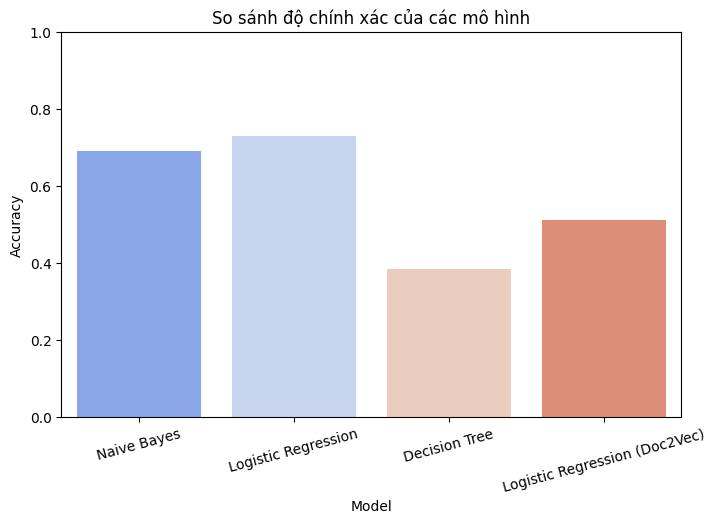

In [ ]:
# So sánh mô hình
models = ["Naive Bayes", "Logistic Regression", "Decision Tree", "Logistic Regression (Doc2Vec)"]
accuracies = [nb_acc, lr_acc, dt_acc, d2v_acc]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette="coolwarm")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("So sánh độ chính xác của các mô hình")
plt.xticks(rotation=15)
plt.show()


In [ ]:
# Huấn luyện Naive Bayes với Laplace smoothing
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_nb = nb_model.predict(X_test)

# Độ chính xác
nb_acc = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", nb_acc)

# Báo cáo chi tiết
print(classification_report(y_test, y_pred_nb))

# In một số kết quả dự đoán
print("\nSample Predictions:")
for i in range(20):  # Hiển thị 10 kết quả đầu tiên
    print(f"Text {i+1}: Actual: {y_test.iloc[i]}, Predicted: {y_pred_nb[i]}")


Naive Bayes Accuracy: 0.695
              precision    recall  f1-score   support

 bóng chuyền       0.77      0.65      0.70      1625
     bóng rổ       0.46      0.23      0.31      1659
     bóng đá       0.41      0.61      0.49      1672
     bơi lội       0.77      0.82      0.80      1655
    cầu lông       0.81      0.88      0.84      1691
        golf       0.78      0.98      0.87      1670
      tennis       0.63      0.40      0.48      1682
    võ thuật       0.79      0.89      0.83      1677
      đua xe       0.81      0.81      0.81      1669

    accuracy                           0.69     15000
   macro avg       0.69      0.69      0.68     15000
weighted avg       0.69      0.69      0.68     15000


Sample Predictions:
Text 1: Actual: bơi lội, Predicted: bơi lội
Text 2: Actual: cầu lông, Predicted: cầu lông
Text 3: Actual: bóng đá, Predicted: võ thuật
Text 4: Actual: bóng chuyền, Predicted: bóng chuyền
Text 5: Actual: bóng rổ, Predicted: bóng rổ
Text 6: Actual:

# Pretrained BERT/PhoBERT

In [ ]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def get_bert_embeddings(texts, model, tokenizer, max_length=256):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Lấy embedding của [CLS] token

# Load BERT và PhoBERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = AutoModel.from_pretrained("bert-base-multilingual-cased").to(device)
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
phobert_model = AutoModel.from_pretrained("vinai/phobert-base").to(device)
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.3, random_state=42, stratify=df["label"])

# Feature Extraction từ BERT và PhoBERT
X_train_bert = get_bert_embeddings(X_train.tolist(), bert_model, bert_tokenizer)
X_test_bert = get_bert_embeddings(X_test.tolist(), bert_model, bert_tokenizer)
X_train_phobert = get_bert_embeddings(X_train.tolist(), phobert_model, phobert_tokenizer)
X_test_phobert = get_bert_embeddings(X_test.tolist(), phobert_model, phobert_tokenizer)

# Huấn luyện Logistic Regression
lr_bert = LogisticRegression(max_iter=1000, C=0.5)
lr_bert.fit(X_train_bert, y_train)
y_pred_bert = lr_bert.predict(X_test_bert)
print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))
print(classification_report(y_test, y_pred_bert))

lr_phobert = LogisticRegression(max_iter=1000, C=0.5)
lr_phobert.fit(X_train_phobert, y_train)
y_pred_phobert = lr_phobert.predict(X_test_phobert)
print("PhoBERT Accuracy:", accuracy_score(y_test, y_pred_phobert))
print(classification_report(y_test, y_pred_phobert))
